In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
import numpy as np
#from PIL import Image
#from PyImagePlot.montage_manager import *

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#df = pd.read_csv("../features/ResNet-152.csv")
#df = pd.read_csv("../features/DG-images/all-cities-ResNet-152.csv")
df = pd.read_csv("../features/rural-ResNet50-pool.csv")

In [ ]:
df.head()

In [4]:
images = df.iloc[:,0]
import re
def getdigit(text):
    return re.compile('\d+').findall(text)
labels = [i.split(getdigit(i)[0])[0] for i in df.iloc[:,0]]

In [5]:
set(labels)

{'../images/DG_Split_jpg/pansharp_',
 '../images/DelhiR',
 '../images/London_R',
 '../images/NYC/NYC_R',
 '../images/RioE_R',
 '../images/SD_R',
 '../images/joburg_R'}

In [6]:
df_mumbai = df[np.array(labels) == '../images/DG_Split_jpg/pansharp_']
df_not_mumbai = df[np.array(labels) != '../images/DG_Split_jpg/pansharp_']

X_mumbai = np.array(df_mumbai.iloc[:,1:])
X_not_mumbai = np.array(df_not_mumbai.iloc[:,1:])

In [7]:
df_mumbai.head()

Unnamed: 0         0         1         2  \
0   ../images/DG_Split_jpg/pansharp_25268.JPG -1.922248 -0.241621 -0.346996   
5    ../images/DG_Split_jpg/pansharp_2408.JPG -0.984498 -1.297141 -2.000106   
14  ../images/DG_Split_jpg/pansharp_23394.JPG  0.172062  0.995401  0.452347   
22  ../images/DG_Split_jpg/pansharp_26559.JPG -0.625624  0.240865  0.423535   
23   ../images/DG_Split_jpg/pansharp_4734.JPG -1.190608 -1.063574 -0.083964   

           3         4         5         6         7         8    ...     \
0  -1.181747 -0.099983 -1.021371 -0.626152  0.513607 -2.620144    ...      
5  -2.685450 -2.805276 -2.528537 -3.137275 -0.707719 -2.595295    ...      
14  1.522826 -0.627380 -0.226454 -0.662125 -0.696071 -3.747400    ...      
22 -0.582743 -0.228144  0.827312 -1.282445 -0.880843 -1.514165    ...      
23 -0.654648 -0.747939 -1.781320 -1.093925 -0.815708 -1.762843    ...      

         990       991       992       993       994       995       996  \
0  -0.935773 -1.962852 -2.851889 -1.702656 -1.051779 -0.585413  0.101140   
5  -1.873586 -3.497085 -3.609992 -1.701002 -0.353334 -0.506763 -0.514030   
14 -0.718896 -0.625884 -1.149811 -0.995385  0.880379  0.294655  1.903533   
22 -2.165830 -1.487972 -1.452907 -1.426471  0.286915 -1.335111 -0.291807   
23 -1.322900 -1.736596 -1.609256 -1.422253 -0.225167 -0.631241  1.701404   

         997       998       999  
0  -2.346792 -1.115641 -0.014950  
5  -2.578002 -0.089934  0.410749  
14 -0.612388 -1.605316 -2.621675  
22 -1.460736 -0.407823 -1.723451  
23 -1.743609 -0.574302 -0.335100  

[5 rows x 1001 columns]

In [8]:
## samples look random enough so just split data into two
X_train = X_mumbai[:2000,:] # 2000 is roughly 10% of data
X_test = X_mumbai[2000:,:]


# for i in range(31,51):
#     km = KMeans(n_clusters=i, init='k-means++',n_init=100, max_iter=5000, random_state=0, n_jobs=-1)
#     km.fit(X_train)
#     scores.append(km.score(X_train))

# width = 8
# height = 6
# plt.figure(figsize=(width, height))
# #plt.plot(np.diff(-1*np.array(scores)), ".")
# plt.plot(range(1,50),np.diff(-1*np.array(scores)), ".")

In [9]:
km = KMeans(n_clusters=50, init='k-means++',n_init=500, max_iter=5000, random_state=0, n_jobs=-4)
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5000,
    n_clusters=50, n_init=500, n_jobs=-4, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [10]:
# clustered_mumbai_train = km.predict(X_train)
# clustered_mumbai_test = km.predict(X_test)
# clustered_mumbai = km.predict(X_mumbai)
# clustered_test = km.predict(np.vstack((X_test, X_not_mumbai)))
# clustered_not_mumbai = km.predict(X_not_mumbai)

In [10]:
import collections

def make_counter_df(input_list):
    counters = collections.Counter(input_list)
    counters_df = pd.DataFrame.from_dict(counters, orient = 'index')
    return counters_df/counters_df.sum()

In [11]:
def organize_images(kmeans_imgs, features, image_paths):
    cluster_orders = RandomizedPCA(n_components=1).fit_transform(kmeans_imgs.cluster_centers_)
    clusters = km.transform(features)
    clusters_distances_ordered = clusters[:,list(np.argsort(list(cluster_orders), axis = 0).squeeze())]
    clusters_df = pd.DataFrame({"image_paths": image_paths, 'cluster': np.argmin(clusters_distances_ordered, axis = 1), 
        'dist': np.min(clusters_distances_ordered*10, axis = 1).astype(int)})
    
    #clusters_df[["image_paths", "cluster", "dist"]].to_csv(filename, index = False)
    #return np.argmin(clusters_distances_ordered, axis = 1)
    return clusters_df

In [12]:
clustered_mumbai_train_ordered = organize_images(km, X_train, df_mumbai.iloc[:2000,0])
clustered_mumbai_test_ordered = organize_images(km, X_test, df_mumbai.iloc[2000:,0])
clustered_not_mumbai_ordered = organize_images(km, X_not_mumbai, df_not_mumbai.iloc[:,0])

/usr/lib64/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/usr/lib64/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DO

In [13]:
clustered_mumbai_train_ordered.head()

cluster  dist                                image_paths
0         9   390  ../images/DG_Split_jpg/pansharp_25268.JPG
5         7   385   ../images/DG_Split_jpg/pansharp_2408.JPG
14       22   327  ../images/DG_Split_jpg/pansharp_23394.JPG
22       35   335  ../images/DG_Split_jpg/pansharp_26559.JPG
23        7   348   ../images/DG_Split_jpg/pansharp_4734.JPG

In [14]:
clustered_mumbai_train_ordered[["image_paths","cluster","dist"]].to_csv("../results/12_cluster_distribution_mumbai_train.csv", 
                                                                    index = False)
clustered_mumbai_test_ordered[["image_paths","cluster","dist"]].to_csv("../results/12_cluster_distribution_mumbai_test.csv", 
                                                                    index = False)
clustered_not_mumbai_ordered[["image_paths","cluster","dist"]].to_csv("../results/12_cluster_distribution_not_mumbai.csv", 
                                                                    index = False)

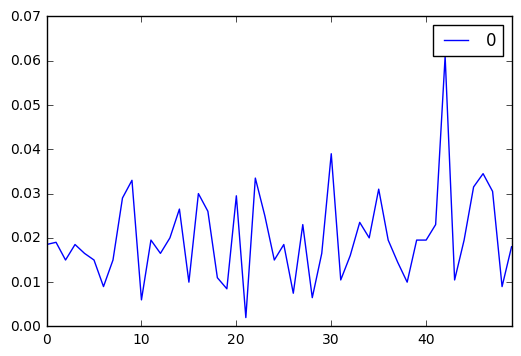

In [15]:
#make_counter_df(clustered_mumbai_train_ordered).to_csv("../results/12_cluster_distribution_mumbai_train.csv", index = False)
make_counter_df(clustered_mumbai_train_ordered.cluster).plot()


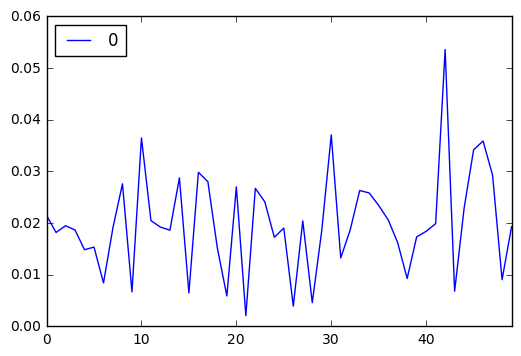

In [16]:
make_counter_df(clustered_mumbai_test_ordered.cluster).plot()

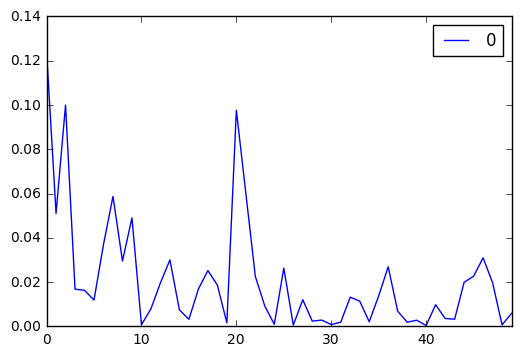

In [17]:
make_counter_df(clustered_not_mumbai_ordered.cluster).plot()

In [70]:
make_counter_df(clustered_mumbai_test).head()

0
0  0.028021
1  0.053593
2  0.029840
3  0.027019
4  0.009056

number of images in Mumbai 555
number of images outside of Mumbai 4708


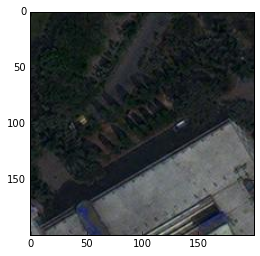

In [209]:
cluster_to_analyze = 48

interesting_cluster = [df_mumbai.iloc[i,0] for i, c in enumerate(clustered_mumbai) if c == cluster_to_analyze]
interesting_cluster_not_mumbai = [df_not_mumbai.iloc[i,0] for i, c in enumerate(clustered_not_mumbai) if c == cluster_to_analyze]

print "number of images in Mumbai", len(interesting_cluster)
print "number of images outside of Mumbai", len(interesting_cluster_not_mumbai)

im = Image.open(interesting_cluster[0])
plt.imshow(im)

In [210]:
df_clustered = pd.DataFrame({'image_paths':interesting_cluster_not_mumbai + interesting_cluster})
df_clustered["city"] = df_clustered.image_paths.apply(lambda x: x.split("/")[-1].split("_")[0])
df_clustered["dummy"] = range(df_clustered.shape[0])

#df_clustered.head()

collections.Counter(df_clustered.city)

Counter({'Delhi': 130,
         'Joburg': 515,
         'London07222014': 163,
         'NYC': 1525,
         'NYCR4C3': 1764,
         'Rio': 319,
         'SD': 292,
         'pansharp': 555})

In [211]:
M = Montages()


montages = M.binned_montage(df_clustered, img_paths_col="image_paths", bins_col="city", vals_col="dummy")

number of images: 515
number of images: 555
number of images: 130
number of images: 319
number of images: 163
number of images: 1525
number of images: 1763
number of images: 292


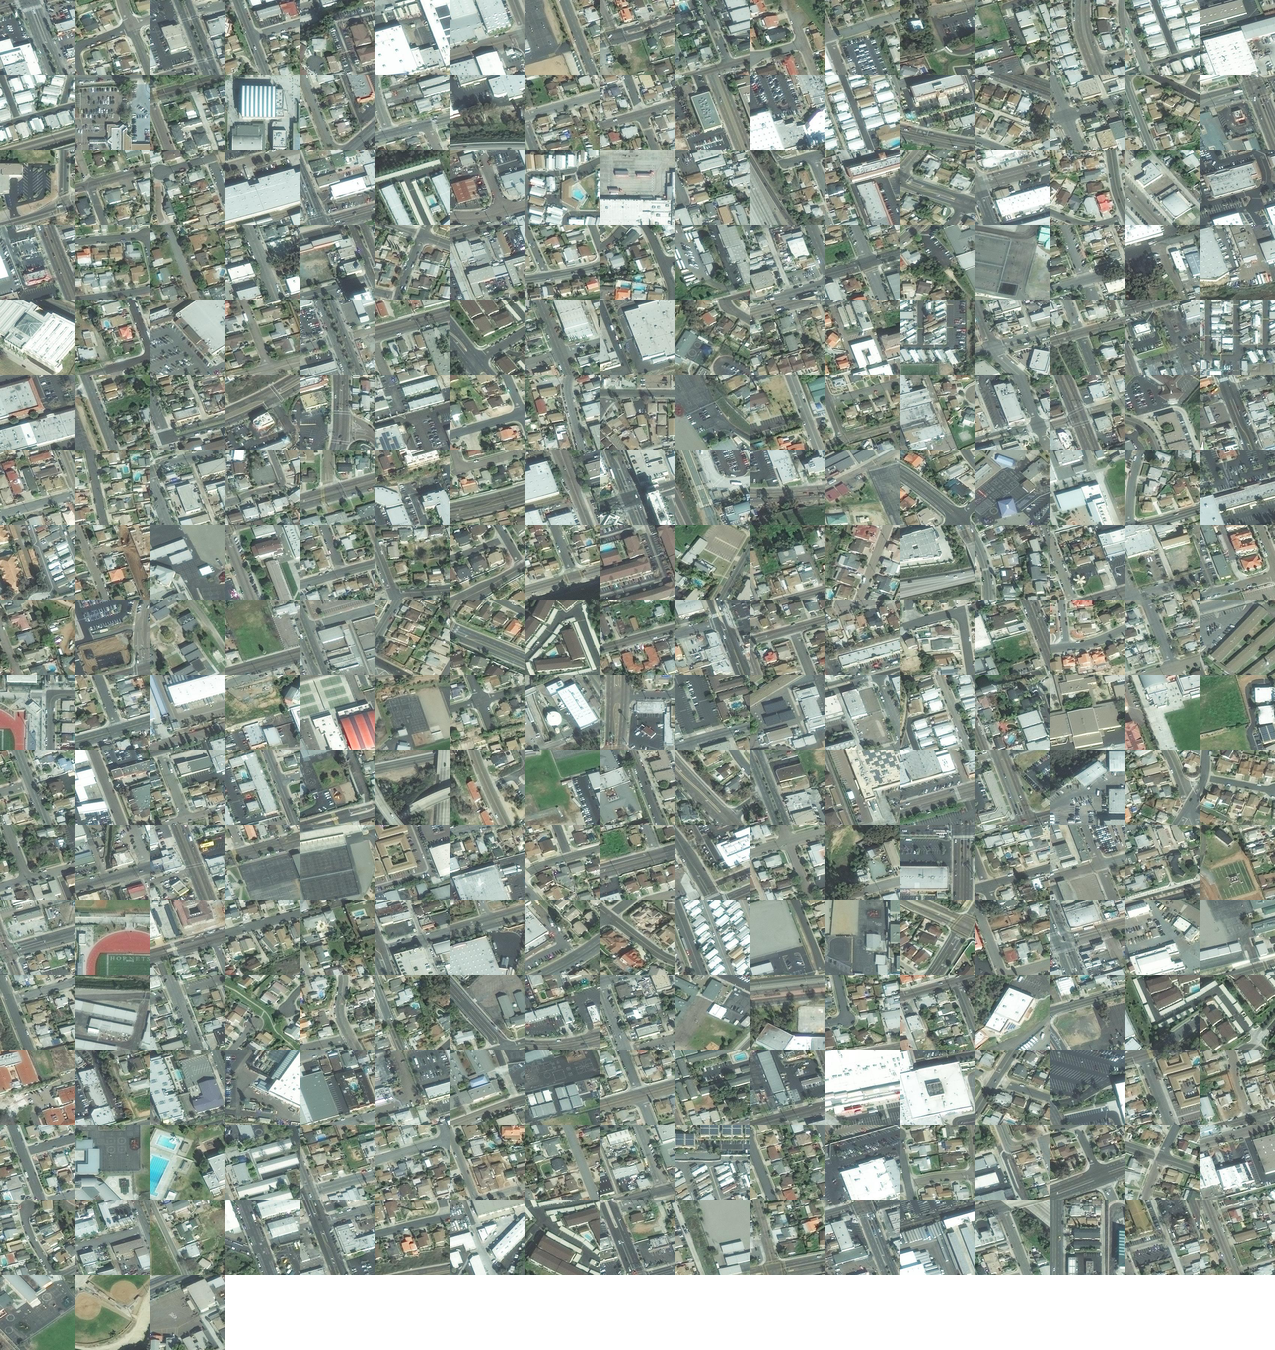

In [206]:
montages[7][0]

In [212]:
df_clustered.to_csv("cluster_48.csv", index = False)

## Visualize cities using image histograms

In [158]:
set(labels)

{'../images/DG_Split_jpg/pansharp_',
 '../images/DelhiR',
 '../images/London_R',
 '../images/NYC/NYC_R',
 '../images/RioE_R',
 '../images/SD_R',
 '../images/joburg_R'}

In [159]:
df_mumbai = df[np.array(labels) == '../images/DG_Split_jpg/pansharp_']
df_delhi = df[np.array(labels) == '../images/DelhiR']
df_london = df[np.array(labels) == '../images/London_R']
df_NYC = df[np.array(labels) == '../images/NYC/NYC_R']
df_rio = df[np.array(labels) == '../images/RioE_R']
df_SD = df[np.array(labels) == '../images/SD_R']
df_joburg = df[np.array(labels) == '../images/joburg_R']

In [169]:
def group_images(kmeans_imgs, features, image_paths, filename):
    cluster_orders = RandomizedPCA(n_components=1).fit_transform(kmeans_imgs.cluster_centers_)
    clusters = img_clusters.transform(features)
    clusters_distances_ordered = clusters[:,list(np.argsort(list(cluster_orders), axis = 0).squeeze())]
    
    clusters_df = pd.DataFrame({"image_paths": image_paths, 'cluster': np.argmin(clusters_distances_ordered, axis = 1), 
              'dist': np.min(clusters_distances_ordered*10, axis = 1).astype(int)})
    clusters_df[["image_paths", "cluster", "dist"]].to_csv(filename, index = False)

In [162]:
img_clusters = KMeans(n_clusters=100, n_init=100, max_iter=1000, n_jobs = -1)
X_mumbai = np.array(df_mumbai.iloc[:,1:])

img_clusters.fit(X_mumbai[:4000,]) # do not use all samples to avoid overfitting and speedup kmeans

KMeans(copy_x=True, init='k-means++', max_iter=1000, n_clusters=100,
    n_init=100, n_jobs=-1, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

In [ ]:
delhi_img_hist = group_images(features=df_delhi.iloc[:,1:], image_paths=df_delhi.iloc[:,0])
london_img_hist = group_images(features=df_london.iloc[:,1:], image_paths=df_london.iloc[:,0])
NYC_img_hist = group_images(features=df_NYC.iloc[:,1:], image_paths=df_NYC.iloc[:,0])
rio_img_hist = group_images(features=df_rio.iloc[:,1:], image_paths=df_rio.iloc[:,0])
SD_img_hist = group_images(features=df_SD.iloc[:,1:], image_paths=df_SD.iloc[:,0])
joburg_img_hist = group_images(features=df_joburg.iloc[:,1:], image_paths=df_joburg.iloc[:,0])

In [171]:
group_images(kmeans_imgs=img_clusters, features=df_mumbai.iloc[:,1:], image_paths=df_mumbai.iloc[:,0],
            filename = "mumbai_img_hist.csv")

In [172]:
group_images(kmeans_imgs=img_clusters, features=df_delhi.iloc[:,1:], image_paths=df_delhi.iloc[:,0],
            filename = "delhi_img_hist.csv")

In [173]:
group_images(kmeans_imgs=img_clusters, features=df_london.iloc[:,1:], image_paths=df_london.iloc[:,0],
            filename = "london_img_hist.csv")

In [174]:
group_images(kmeans_imgs=img_clusters, features=df_NYC.iloc[:,1:], image_paths=df_NYC.iloc[:,0],
            filename = "NYC_img_hist.csv")

In [175]:
group_images(kmeans_imgs=img_clusters, features=df_rio.iloc[:,1:], image_paths=df_rio.iloc[:,0],
            filename = "rio_img_hist.csv")

In [176]:
group_images(kmeans_imgs=img_clusters, features=df_SD.iloc[:,1:], image_paths=df_SD.iloc[:,0],
            filename = "SD_img_hist.csv")

In [177]:
group_images(kmeans_imgs=img_clusters, features=df_joburg.iloc[:,1:], image_paths=df_joburg.iloc[:,0],
            filename = "joburg_img_hist.csv")